# Fake Political News Detection using CNN, DNN, LSTM

## Overview
This notebook contains step-by-step development and walkthough of fake news classification using Convolutional Neural Network, Deep Neural Network, and Long Short-Term Memory (Recurrent Neural Network) architecture. It includes the end-to-end design that covers the 6Ds of creating AI-enabled systems. 

**_NOTE_**: As the Golve Embedding file is larger then 100MB it can not be uploaded to github, but it can be downloaded from this [link](https://nlp.stanford.edu/projects/glove/?msclkid=17352c13cf3111ecb36fc6395436b39d). Download glove.6B.zip  and extract glove.6B.50d.txt from the zip. Put the file int he same directory as this jupyter lab notebook directory.

## Decomposition


Receiving latest news in the model era has become much easier due to the technology. This raises the concern for the validity of the news. Even if the news is fake it will also spread much quicker and before it is proven to be fake, it will have done some damage. There are many types of news we could focus on such as sports, business, general, crime, but political news effects our day to day life more than any other type of news. After reading/hearing news some people research the topic to determine the validity of the news which is time consuming. Having a classification model validate the news could help speed up the research process or act as a middle man that validates the news before it is brought in front of the people.The simple principle behind this project is to decrease the effects the fake news has in the works and allow the users to gain confidence in the information they consume.<br><br>

**Decomposition of the process**

Validating news requires labeled dataset of real and fake news. Once the data is collected the next step is to train the model to learn human writting patterns. The last step is to deploy the product and make it available for the users.

## Domain Expertise

This project would require policitcal experts for news labeling as well determining how the fake news can be detected. This would allow the AI developers to understand what kind of patterns the model needs to extract to be able to validate the news. The false positive classification could lead to the change in the environment around user such as the early retirement of a political leader or sudden change in the stock prices which leads to product prices going up. False negative would lead to similar effects like voting for the wrong official. The false negetive classification and false positive classification both could damage the economy equally so accuracy is very important to gain the trust of the user in the model.<br><br>


**How does an AI detect fake news?**

Fake news does not always have taletell signs. In some cases, we could find some grammatical, and spelling mistakes which could be an indication of fake news. An AI clould be developed by feeding it huge virtual data libraries that contain authentic information and sources to help AI learn the patterns of human writing.


## Data
Data collection for this project is easier as there are huge labeled virtual data libraries containing news articles to train the AI. We can also leverage online resources such as [FactCheker.org](https://www.factcheck.org/), [Snopes.com](https://www.snopes.com/fact-check/), [Google Fact Check Tool](https://www.snopes.com/fact-check/), [politifact.com](https://www.politifact.com/), etc... </br></br> 

For this project we will be utalizing [Kaggle Fake & Real News Dataset](https://www.kaggle.com/datasets/hassanamin/textdb3) which is a dataset of 6335 news articles with 50% real and 50% fake news. The dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (FAKE, REAL)

In [18]:
#import general packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scikeras.wrappers import KerasClassifier
import pickle, os, json, re, requests

#import sklearn packsges
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

#import nltk packages
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
nltk.download('stopwords')
nltk.download('wordnet')

# import keras packages
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Input, Flatten, Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GlobalMaxPooling1D
from keras.models import Model, Sequential

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# set the flag for tensorflow CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [20]:
# path variables
EMBEDDING_DIM = 50
dataset_path = "fake_or_real_news.csv"
embedding_path = "glove.6B.50d.txt"
save_keras_model_path = 'FlaskServer/artifacts/keras_artifacts'
save_tokenizer_path = 'FalskServer/artifacts/tokenizer.pickle'

### Explore & Optimize

In [15]:
# Read the dataset
df = pd.read_csv(dataset_path)
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [17]:
# drop id, title colmns
df = df.drop(['Unnamed: 0', 'title'], axis=1)
df

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
6330,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [18]:
# Check for null values
df.isnull().sum()

text     0
label    0
dtype: int64

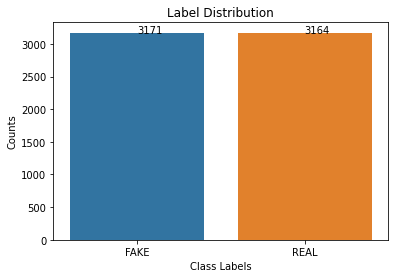

In [19]:
# drop null values
df = df.dropna()  
      
# plot class distribution
sns.countplot(x = df['label'])
for index, value in enumerate([df['label'].value_counts()[0], df['label'].value_counts()[1]]):
    plt.text(index, value,  str(value))
plt.xlabel("Class Labels")
plt.ylabel("Counts")
plt.title("Label Distribution")
plt.show()

### Preprocessing

The below function removes stopwords, and punctuations. It also applies PotterStemmer,  world net lemmatization, and sets the final string as lower case.  

In [20]:
# Preprocessing
def pre_process_news(news):
    """
      The function applies the WordNetLemmatization , PotterStamming, stop word removal, and punctuation removal on the string for preprocessing.

       Parameters: 
           news: string that needs to be pre-processed

       Returns:
           processed string
    """
    
    lemm = WordNetLemmatizer()
    ps = PorterStemmer() 
    stop_words = set(stopwords.words('english'))
    news = news.lower()
    news = re.sub("[^0-9a-z]", ' ' , news) # removes punctuations
    tokenized = news.split(" ")
    news = [ ps.stem(word) for word in tokenized if word not in stop_words] # apply stemming and drop stopwords
    news = " ".join(news)  # join the tokens into a string
    news = lemm.lemmatize(news)  # apply lemmatization
    return news

In [21]:
# encode categorical data to numerical
df.loc[df['label']=='FAKE', 'label'] = 0    # FAKE = 0
df.loc[df['label']=='REAL', 'label'] = 1    # REAL = 1

In [22]:
# apply preprocessing to the news text
df['processed_text'] = df['text'].apply(lambda news : pre_process_news(news))

In [23]:
# seperate the processed data from labels
data = df["processed_text"]
labels = df["label"].to_numpy().ravel()

In [24]:
# tokenize data
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts = data)
tokenized_data = tokenizer.texts_to_sequences(texts = data)

In [25]:
# pad sequences
MAX_PAD_SEQUENCE_LENGTH = 3000
data = pad_sequences(sequences= tokenized_data, maxlen = MAX_PAD_SEQUENCE_LENGTH)

In [26]:
print("The shape of the data is", data.shape)

The shape of the data is (6335, 3000)


In [27]:
# split dataset to training and testing with stratify
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)
print("x_train size:", x_train.shape)
print("y_train size:", y_train.shape)
print("x_test size:", x_test.shape)
print("y_test size:", y_test.shape)
print("x_valt size:", x_val.shape)
print("y_valt size:", y_val.shape)

x_train size: (4561, 3000)
y_train size: (4561,)
x_test size: (1267, 3000)
y_test size: (1267,)
x_valt size: (507, 3000)
y_valt size: (507,)


In [28]:
# Load pre-trained GloVe encoding
file = open(embedding_path , encoding="utf8")
embedding_dict = {}
for line in file:
    values = line.split()
    embedding_dict[values[0]] = values[1:]
file.close()

In [30]:
# create an embedding matrix
embedding_m = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM)) # since we chose the embedding with 100 dimentions
for word, indx in tokenizer.word_index.items():
    vector = embedding_dict.get(word)
    if vector:    # if there is no embedding for a word then it is left as 0 vector
        embedding_m[indx] = vector
print("The shape of embedding matrix", embedding_m.shape)

The shape of embedding matrix (45456, 50)


In [31]:
# Convert the data to correct format and datatype
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_val = np.asarray(x_val).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

## Design

For this project we utilize Convolutional Neural Network, Deep Neural Network, and Long Short-Term Memroy (Recurrent Neural Network). Below we use different neural network architectures to learn human writting patterns to classify news. The models use pre-trained GloVe encoding layers where each entry is encoded into a vector of 50 dimentions. Further explanation of the the neural network architecture model can be found below.

**About Data**

The training data was preprocessed and tokenized above. The tokenized dictionary contains key pairs of a unique number to a unique word.Each row of the dataset is a list of numbers, each containing the index value of the corresponding words in the tokenized dictionary. The pre-trained GloVe encoding is loaded and converted to a matrix. If the first index value in tokenized dictionary is "men" then the first row in the embedding matrix contains the embedding for the word "men". This allows us to use the index mapping from the tokenized dictionary for embedding. 

### CNN Model

A convolutional neural network, or CNN, is a deep learninng network designed for processing structured arrays of data such as images. CNN are widely used for computer vision and natural language processing for text classification. CNN is a feed-forward neural network and its power comes from the convolutional layer. THe usage of the convolutional layers in a convolutional neural network mirros the structure of the human visual cortex where layers process an incoming input and identify complex features.

The model below takes the data and embeds it on the GloVe embedding, followed by convolutional filter, maxpooling, flatening, and dense layers.

* **Embedding Layer**: Turns positive integer into a dense vector of size 100. As shows below each work has a embedding. In the below picture word groot has embedding of 2 elements. In our case we have an embedding of 50 elements for each word.

<img src="images/embedding.PNG" alt="Embedding Visual" style="width: 200px;"/>

* **Convolution Layer**: Creates a convolution kernel that is convolved with the layer input over a single spatial dimension to produce a tensor of outputs. Visual example below.

<img src="images/Convolution.PNG" alt="Convolution Visual" style="width: 600px;"/>

* **Maxpooling Layer**: Downsamples the input representation by taking the maximum value over a spatial window of given size. Visual example below.

<img src="images/maxpooling.png" alt="Maxpooling Visual" style="width: 600px;"/>

* **Flatten Layer**: Flattens the input meaning it converts a nxm matrix to a list of values. Visual example below.

<img src="images/flattening.png" alt="Flattening Visual" style="width: 500px;"/>

* **Dense Layer**: It helps change the dimentionality of the output from preceding layer through the activation function.

In [32]:
def pred_acc(model, x_test, y_test):
    """
    The function tests the trained model using test data and prints performance metrics.
    
    Parameters:
        model: the trained model to use for prediction making
        x_test: test data
        y_test: test data labels
    
    Returns:
        None
    """
    
    print("Starting to test the model...")
    y_preds = model.predict(x_test)
    y_pred = np.round(y_preds).ravel()
    cm = confusion_matrix(y_test, y_pred)
    c_pred = cm[0,0] + cm[1,1]
    acc = accuracy_score(y_pred, y_test)
    print("\n# Correct predictions:", c_pred)
    print("\n# Total tests attempted:", len(y_test))
    print("\nAccuracy of the model: ", acc) 
    print('\nConfusion Matrix:\n', cm)
    
    print("classification Report")
    print(classification_report(y_test, y_preds, target_names = ['Fake','Real']))

    print("\n")
    plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.show()

In [33]:
def grid_search(model_func, params, x_train, y_train):
    """
      The applices using params on model_func, and tests it using x_tran and y_train.

      Parameters:
        model_func: model we want to apply grid search on
        x_train: training data
        y_train: training data labels
        params: parameters we want to test

      Returns:
        returns gridsearch model which contains metrics from the GridSearch operation
    """
    model = KerasClassifier(build_fn=model_func)
    gs = GridSearchCV(model, params, cv=2, scoring = 'f1')
    gs.fit(x_train, y_train)
    
    print("\n\n\nThe best parameters", gs.best_params_)
    print("The best score for best parameters", gs.best_score_)
    
    print("Grid Search Results")
    display(pd.DataFrame(gs.cv_results_))
    
    return gs

### CNN

In [34]:
def CNN_model():
    """
    The function sets up the layers of the model.
    
    Parameters: 
        None
    Returns:
        built convolutional neural network model
    """
    
    cnn = Sequential(
        [
            Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIM, weights=[embedding_m], input_length=x_train.shape[1]),
            Conv1D(32, 5, activation='relu'),
            MaxPooling1D(5),
            Conv1D(16, 5, activation='relu'),
            Flatten(),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

    cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    cnn.summary()

    return cnn

### CNN - GridSearch

In [35]:
#gridsearch on CNN
params = {'epochs': [7, 10, 15],
          'batch_size': [16, 32]}
gs_cnn = grid_search(CNN_model, params, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 50)          2272800   
                                                                 
 conv1d (Conv1D)             (None, 2996, 32)          8032      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 599, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 595, 16)           2576      
                                                                 
 flatten (Flatten)           (None, 9520)              0         
                                                                 
 dense (Dense)               (None, 16)                152336    
                                                        

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,17.538411,6.574603,0.426556,0.006765,16,7,"{'batch_size': 16, 'epochs': 7}",0.880824,0.888698,0.884761,0.003937,3
1,16.170536,5.068193,0.419487,0.003051,16,10,"{'batch_size': 16, 'epochs': 10}",0.872340,0.899911,0.886126,0.013786,1
2,29.433560,12.950714,0.423046,0.004342,16,15,"{'batch_size': 16, 'epochs': 15}",0.880847,0.890543,0.885695,0.004848,2
3,5.778815,0.009105,0.425003,0.000119,32,7,"{'batch_size': 32, 'epochs': 7}",0.856900,0.895575,0.876238,0.019338,5
4,9.452773,1.541527,0.535834,0.220447,32,10,"{'batch_size': 32, 'epochs': 10}",0.869872,0.875906,0.872889,0.003017,6
5,17.288697,4.931318,0.360769,0.062208,32,15,"{'batch_size': 32, 'epochs': 15}",0.883925,0.880889,0.882407,0.001518,4


### DNN

Deep neural network is also known as fast forward neural network as the data will only flow in forward direction. DNN structure contains an input layer, a output layer and multiple hidden layers. DNN is a somple neural network that processsed data in a complex ways by employing sophisticated math modeling. 

Deep neural network below utalizes embedding, densem and convolution layers as described above. Additionally it uses GlobalMaxPooling, which allows the AI to use the golbal maximum value/features during the computations.


![DNN visual](images/DNN.png)

In [37]:
def DNN_model():
    """
    The function sets up the layers of the model.
    
    Parameters: 
        None
    Returns:
        built deep neural network model
    """
    dnn = Sequential(
      [
          Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIM, weights=[embedding_m], input_length=x_train.shape[1]),
          Conv1D(128, 3, activation='relu'),
          GlobalMaxPooling1D(),
          Dense(64, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    dnn.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

    dnn.summary()
    return dnn

### DNN - GridSearch

In [38]:
params = {'epochs': [10, 15, 20],
          'batch_size': [64]}

gs_dnn = grid_search(DNN_model, params, x_train, y_train)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 3000, 50)          2272800   
                                                                 
 conv1d_26 (Conv1D)          (None, 2998, 128)         19328     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,300,449
Trainable params: 2,300,449
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


36/36 [==============================] - 2s 29ms/step - loss: 0.6150 - accuracy: 0.6759
Epoch 2/10
36/36 [==============================] - 1s 26ms/step - loss: 0.4258 - accuracy: 0.8070
Epoch 3/10
36/36 [==============================] - 1s 26ms/step - loss: 0.3131 - accuracy: 0.8825
Epoch 4/10
36/36 [==============================] - 1s 26ms/step - loss: 0.2325 - accuracy: 0.9193
Epoch 5/10
36/36 [==============================] - 1s 26ms/step - loss: 0.1851 - accuracy: 0.9461
Epoch 6/10
36/36 [==============================] - 1s 26ms/step - loss: 0.1474 - accuracy: 0.9548
Epoch 7/10
36/36 [==============================] - 1s 26ms/step - loss: 0.1030 - accuracy: 0.9746
Epoch 8/10
36/36 [==============================] - 1s 27ms/step - loss: 0.0742 - accuracy: 0.9833
Epoch 9/10
36/36 [==============================] - 1s 26ms/step - loss: 0.0517 - accuracy: 0.9930
Epoch 10/10
36/36 [==============================] - 1s 26ms/step - loss: 0.0380 - accuracy: 0.9947
Model: "sequential_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,11.030955,0.006216,0.715661,0.000770,64,10,"{'batch_size': 64, 'epochs': 10}",0.888889,0.904660,0.896775,0.007886,3
1,21.268493,0.009506,0.633594,0.083005,64,15,"{'batch_size': 64, 'epochs': 15}",0.912049,0.909169,0.910609,0.001440,1
2,20.628574,0.696088,0.718364,0.000343,64,20,"{'batch_size': 64, 'epochs': 20}",0.919842,0.894279,0.907061,0.012782,2


### LSTM

Long-short term memory(LSTM) is an advanced architecture of recurrent neural network(RNN) which handles situations where RNN fails. LSTM are developed to deal with the vanishing gradient problem that can be encountered while training tradition RNNs. It is a special network that is capable of learning long term dependencies in data. An LSM helps the information to flow through the units without being altered by allowing only a few linear interactions.

<img src="images/LSTM.PNG" alt="LSTM Visual" style="width: 500px;"/>

The below LSTM model utalizes Embedding, LSTM and Dense layers only as it requires a lot of processing power. Similary to above models we compile the model using binary_crossentropy loss and adam optimizer.

In [42]:
def LSTM_model():
    """
    The function sets up the layers of the model.
    
    Parameters: 
        None
    Returns:
        built bidirectional long short-term memory model
    """
    lstm = Sequential(
         [
              Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIM, weights=[embedding_m], input_length=x_train.shape[1]),
              LSTM(units=128),
              Dense(64, activation='relu'),
              Dense(1, activation='sigmoid')
         ])
    lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    lstm.summary()

    return  lstm

### LSTM - GridSearch

In [43]:
params = {'epochs': [6, 12, 20],
          'batch_size': [64]}
gs_lstm = grid_search(LSTM_model, params, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 3000, 50)          2272800   
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,372,769
Trainable params: 2,372,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
36/36 [==============================] - 7s 134ms/step - loss: 0.6183 - accuracy: 0.6592
Epoch 2/6
36/36 [==============================] - 5s 130ms/step - loss: 0.5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,39.119032,3.758735,3.962258,0.508204,64,6,"{'batch_size': 64, 'epochs': 6}",0.816568,0.830068,0.823318,0.006750,3
1,72.042257,11.799048,4.486746,0.991414,64,12,"{'batch_size': 64, 'epochs': 12}",0.862450,0.846430,0.854440,0.008010,1
2,121.566849,23.376482,4.499442,0.981037,64,20,"{'batch_size': 64, 'epochs': 20}",0.841242,0.853893,0.847568,0.006325,2


The above tests were ran multiple times on free version of Google Colab GPU as I did not have access to Nvidia GPU. The above tests were done multiple times to determine the the best combination of layers that give the best performance. The above output is the best combinaation of layers, which was found after some testing. What can be learned from the above data is that feed forward networks like DNN and CNN require a large quantity of labeled data to truly shine. This also requires much higher computation power as well. The runtime and the performace of the models can be observed above in the gridsearch process at well as teh table displayed at the end of the gridsearch process.

The google colab uses Python 3 Google Compute Engine backend(GPU) with limited RAM and GPU access.   

### Train final model with best parameters

In [46]:
# Train the best model using the best parameters on all 90% data and 10% validation
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=42, stratify=labels)

# Convert the data to correct format and datatype
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_val = np.asarray(x_val).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)

# re-train the model
dnn = DNN_model()
history_dnn = dnn.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=15, batch_size=128)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 3000, 50)          2272800   
                                                                 
 conv1d_35 (Conv1D)          (None, 2998, 128)         19328     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_58 (Dense)            (None, 64)                8256      
                                                                 
 dense_59 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,300,449
Trainable params: 2,300,449
Non-trainable params: 0
___________________________________________

## Diagnosis

The models learn about the human writting patterns to determine is a news is real or false as such it would fail the classification if the fake news was also generated by an AI. The model would also fail to correctly classify if the user attemps to classify other types of news such as sports. Each of the models above utilizes pre-trained GloVe encoding which might also contain bias. 

**Scoping**- The simple principle behind this project is to decrease the effects the fake news has in the works and allow the users to gain confidence in the information they consume. An area of source harm would be the bias found in labeled news dataset or the bias from GloVe embedding.
 
**Mapping**- The false positive classification could lead to the change in the environment around user such the early retirement of a political leader or sudden change in the stock prices which leads to product prices going up. False negative would lead to similar effects like voting for the wrong official.
 
**Artifact Collection**- The assumption made for the dataset is that it does not contain bias. The requires labeled data is availabe virtually at large quantity.

**Testing**- The model would be built after extensive testing using neural networks such as CNN, DNN, LSTM. We also test the models with diverse news data. 

To futher improve the model we could train a different types of news like politics, sports, etc.  We could also have multiple experts in a field label the dataset so as to avoid bias. Another option is to get more data as some neural network require large quantity of data.

## Deployment
A simple strategy  to deploy the model is to create an API that could be accesed by anyone easily. We could consider using serverless AWS server to create and API and make predictions using API. Another option is to create an restful API using flask and and make API request for a prediction. For the deployment of this project A flask AI was created which can be found in the FlaskServer, server.py file. A simple GET call to confirm the connection to the server, as the POST call used used to take the input from the news input from the user to make a prediction on. The below picture depicts the deployment cycle. The model can be updated and deployed to GitHub for version control as well as being published to DockerHub to make it avaibale to the user. This process can be improved using my creating an API using cloud services uploading the saved model on cloud as discussed earlier.

<img src="images/deployment.JPG" alt="model deployment" style="width: 800px;"/>

### Save info - for predition steps

In [ ]:
# Save keras model
dnn.save(filepath = save_keras_model_path)

#Save embedding dictionary
with open(save_tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Test Flask API

Read the readme.md for instructions on how to run the flask server

**_Note_** : This notebook should be running inside the container for a connection to flask server.

In [15]:
# Copy oase the news article in the following format  text = """ news """. As show below.
text = """
	text
9	Hillary Clinton and Donald Trump made some inaccurate claims during an NBC “commander-in-chief” forum on military and veterans issues:

• Clinton wrongly claimed Trump supported the war in Iraq after it started, while Trump was wrong, once again, in saying he was against the war before it started.

• Trump said that President Obama set a “certain date” for withdrawing troops from Iraq, when that date was set before Obama was sworn in.

• Trump said that Obama’s visits to China, Saudi Arabia and Cuba were “the first time in the history, the storied history of Air Force One” when “high officials” of a host country did not appear to greet the president. Not true.

• Clinton said that Trump supports privatizing the Veterans Health Administration. That’s false. Trump said he supports allowing veterans to seek care at either public or private hospitals.

• Trump said Clinton made “a terrible mistake on Libya” when she was secretary of State. But, at the time, Trump also supported U.S. action that led to the removal of Moammar Gadhafi from power.

• Trump cherry-picked Clinton’s words when he claimed Clinton said “vets are being treated, essentially, just fine.” Clinton had said the problems in the Department of Veterans Affairs were not as “widespread” as some Republicans claimed, but she went on to acknowledge problems, including the issue of wait times for doctors.

The forum, sponsored by NBC News and the Iraq and Afghanistan Veterans of America, was held Sept. 7 at the Intrepid Sea, Air & Space Museum in New York City. Today show host Matt Lauer, and members of the military and veterans in the audience, questioned the candidates separately.

Trump said he “was totally against the war in Iraq,” while Clinton claimed that he supported the Iraq War before and after it started. The facts don’t support either candidate’s strong assertions.

Our review of Trump’s statements before and after the Iraq War started found no evidence that Trump opposed the war before it started. In fact, he expressed mild support for invading Iraq when asked about it on the Howard Stern radio show on Sept. 11, 2002 — about six months before the war started.

Stern asked Trump if he supported a war with Iraq, and Trump responded, “Yeah, I guess so.”

In the NBC commander in chief forum, Trump cited an Esquire article that appeared in August 2004 to show his opposition to the war. But that article appeared 17 months after the war started.

As for Clinton, who as a senator voted in October 2002 to authorize the war in Iraq, the Democratic nominee claimed that Trump “supported it before it happened, he supported it as it was happening and he is on record as supporting it after it happened.”

But just as there is no evidence that Trump opposed the Iraq War before it started, the Clinton campaign offered no evidence that Trump supported the war “after it happened.”

The Clinton campaign cited Trump’s interview on March 21, 2003, with Neil Cavuto of Fox Business just two days after the war started.

Cavuto asked Trump about the impact of the war on the stock market. Trump said the war “looks like a tremendous success from a military standpoint,” and he predicted the market will “go up like a rocket” after the war. But Cavuto does not ask Trump whether the U.S. should have gone to war with Iraq or whether he supports the war, and Trump doesn’t offer an opinion.

As early as July 2003, Trump expressed concern on Hardball with Chris Matthews about money being spent in Iraq rather than in the U.S. Two months later, Trump told MSNBC’s Joe Scarborough, “I guess maybe if I had to do it, I would have fought terrorism but not necessarily Iraq.”

Clinton invited her audience to read Trump’s comments on the Iraq War. They can read our timeline, “Donald Trump and the Iraq War.”

Trump said President Obama set a “certain date” for withdrawing troops from Iraq, but that date was actually set by President George W. Bush.

NBC’s Matt Lauer asked Trump about his tendency to respond, when pushed for details on his military proposals, that he’s not going to give details because he wants to be “unpredictable.” Trump responded, “Absolutely,” and went on to criticize Obama for revealing the withdrawal date.

As we said then, Republicans and Democrats disagree on whether Obama or Bush is to blame for withdrawing all combat troops from Iraq at the end of 2011. But that date was set when Bush signed the Status of Forces Agreement on Dec. 14, 2008. It said: “All the United States Forces shall withdraw from all Iraqi territory no later than December 31, 2011.”

In the NBC forum, Trump also called the withdrawal of troops “a terrible decision.” As we’ve explained before, Condoleezza Rice, Bush’s secretary of State, later wrote that Bush wanted an agreement for a residual force to remain, but Iraqi Prime Minister Nouri al-Maliki objected.

Once Obama took office in January 2009, he had three years to renegotiate the deal, which his administration tried to do, to leave a residual American troop force. But Maliki still didn’t agree. Negotiations broke down in October 2011 over the issue of whether U.S. troops would be shielded from criminal prosecution by Iraqi authorities. Whether Obama did enough is a matter of opinion: His then defense secretary, Leon Panetta, later wrote that the president didn’t press hard enough for a deal. But some experts say Iraq was more closely aligned at the time with Iran and there wasn’t a deal to be made with Maliki.

So, both presidents had a role in the withdrawal of troops. But Trump wrongly said that Obama was the one who set a “certain date” for withdrawal and let U.S. enemies know about it, when that date was set before Obama was sworn in.

It’s worth noting that Trump said in a March 16, 2007, interview on CNN that the troops should be withdrawn quickly from Iraq.

Trump said that Obama’s visits to China, Saudi Arabia and Cuba were “the first time in the history, the storied history of Air Force One” when “high officials” of a host country did not appear to greet the president.

That’s not true. Other presidents have encountered similar low-key greetings on foreign trips aboard the presidential aircraft."""

### Example client below for Flask GET and POST API

In [16]:
import requests, json

In [17]:
# Test the connection with the flask server
response = requests.get("http://127.0.0.1:5001/")
print('response', response.json())

response {'label': 'Successful connection to server.'}


In [14]:
# Make the POST request to predict the validity of the news.
data = {'news': text}
response = requests.post(url="http://127.0.0.1:5001/", data = data)
print('response', response.json() if str(response) != '<Response [500]>' else response)

response {'prediction': 'Real'}


### References
[1] C. K. Hiramath and G. C. Deshpande, "Fake News Detection Using Deep Learning Techniques," 2019 1st International Conference on Advances in Information Technology (ICAIT), 2019, pp. 411-415, doi: 10.1109/ICAIT47043.2019.8987258.

[2] A. J. Keya, S. Afridi, A. S. Maria, S. S. Pinki, J. Ghosh and M. F. Mridha, "Fake News Detection Based on Deep Learning," 2021 International Conference on Science & Contemporary Technologies (ICSCT), 2021, pp. 1-6, doi: 10.1109/ICSCT53883.2021.9642565.

[3] M. Umer, Z. Imtiaz, S. Ullah, A. Mehmood, G. S. Choi and B. -W. On, "Fake News Stance Detection Using Deep Learning Architecture (CNN-LSTM)," in IEEE Access, vol. 8, pp. 156695-156706, 2020, doi: 10.1109/ACCESS.2020.3019735.

[4] T. Bolukbasi, K.-W. Chang, J. Zou, V. Saligrama, and A. Kalai, “Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings,” arXiv:1607.06520 [cs, stat], Jul. 2016, Accessed: May 08, 2022. [Online]. Available: https://arxiv.org/abs/1607.06520?msclkid=14e6b1decea211eca7c294a30bddb6e3

[5] K. Kim and C. Jeong, "Fake News Detection System using Article Abstraction," 2019 16th International Joint Conference on Computer Science and Software Engineering (JCSSE), 2019, pp. 209-212, doi: 10.1109/JCSSE.2019.8864154.

[6] A. Khalil, M. Jarrah, M. Aldwairi and Y. Jararweh, "Detecting Arabic Fake News Using Machine Learning," 2021 Second International Conference on Intelligent Data Science Technologies and Applications (IDSTA), 2021, pp. 171-177, doi: 10.1109/IDSTA53674.2021.9660811.

[7] C. K. Hiramath and G. C. Deshpande, "Fake News Detection Using Deep Learning Techniques," 2019 1st International Conference on Advances in Information Technology (ICAIT), 2019, pp. 411-415, doi: 10.1109/ICAIT47043.2019.8987258.

[8] T. Jiang, J. P. Li, A. U. Haq and A. Saboor, "Fake News Detection using Deep Recurrent Neural Networks," 2020 17th International Computer Conference on Wavelet Active Media Technology and Information Processing (ICCWAMTIP), 2020, pp. 205-208, doi: 10.1109/ICCWAMTIP51612.2020.9317325.

[9] N. Smitha and R. Bharath, "Performance Comparison of Machine Learning Classifiers for Fake News Detection," 2020 Second International Conference on Inventive Research in Computing Applications (ICIRCA), 2020, pp. 696-700, doi: 10.1109/ICIRCA48905.2020.9183072.

[10] B. Majumdar, M. RafiuzzamanBhuiyan, M. A. Hasan, M. S. Islam and S. R. H. Noori, "Multi Class Fake News Detection using LSTM Approach," 2021 10th International Conference on System Modeling & Advancement in Research Trends (SMART), 2021, pp. 75-79, doi: 10.1109/SMART52563.2021.9676333.

[11] P. Shrivastava and D. K. Sharma, "Fake Content Identification Using Pre-Trained Glove-Embedding," 2021 5th International Conference on Information Systems and Computer Networks (ISCON), 2021, pp. 1-6, doi: 10.1109/ISCON52037.2021.9702379.

[12] A. Kishwar and A. Zafar, "Predicting Fake News using GloVe and BERT Embeddings," 2021 6th South-East Europe Design Automation, Computer Engineering, Computer Networks and Social Media Conference (SEEDA-CECNSM), 2021, pp. 1-6, doi: 10.1109/SEEDA-CECNSM53056.2021.9566243.